In [1]:
from matplotlib.colors import ListedColormap
from sklearn import model_selection, datasets, linear_model, metrics, ensemble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from math import exp

In [2]:
def binominalization_0001(X):
    # 0001 - A
    # 0010 - C
    # 0100 - G
    # 1000 - T
    X_b = []
    for i in range(len(X)):
        X_b.append([])
        for j in range(len(X[i])):
            if X[i][j] == "A":
                X_b[i].append(0)
                X_b[i].append(0)
                X_b[i].append(0)
                X_b[i].append(1)
            elif X[i][j] == "C":
                X_b[i].append(0)
                X_b[i].append(0)
                X_b[i].append(1)
                X_b[i].append(0)
            elif X[i][j] == "G":
                X_b[i].append(0)
                X_b[i].append(1)
                X_b[i].append(0)
                X_b[i].append(0)
            elif X[i][j] == "T":
                X_b[i].append(1)
                X_b[i].append(0)
                X_b[i].append(0)
                X_b[i].append(0)
    return np.array(X_b)


def binominalization_01(X):
    # 00 - A
    # 01 - C
    # 10 - G
    # 11 - T
    X_b = []
    for i in range(len(X)):
        X_b.append([])
        for j in range(len(X[i])):
            if X[i][j] == "A":
                X_b[i].append(0)
                X_b[i].append(0)
            elif X[i][j] == "C":
                X_b[i].append(0)
                X_b[i].append(1)
            elif X[i][j] == "G":
                X_b[i].append(1)
                X_b[i].append(0)
            elif X[i][j] == "T":
                X_b[i].append(1)
                X_b[i].append(1)
    return np.array(X_b)

In [3]:
df = pd.read_csv("norm_data.csv")
df = df.to_numpy()
df=df.T
X = binominalization_0001(df[1])
X.astype('float32')
#X = X.T
print(X.shape)
y = df[2]
a = max(y)
y = y.astype('float32')
y = np.array(y+1)
y_st = np.log(y)
y_st = (y_st/y_st.std())
y_st = 4*(y_st - y_st.mean()) + 18
y = y_st

(29337, 144)


(array([2.000e+00, 1.800e+01, 6.000e+01, 1.240e+02, 2.040e+02, 2.210e+02,
        1.820e+02, 1.380e+02, 2.140e+02, 3.920e+02, 7.970e+02, 1.269e+03,
        1.765e+03, 2.063e+03, 2.240e+03, 2.274e+03, 2.108e+03, 1.823e+03,
        1.493e+03, 1.235e+03, 1.024e+03, 9.000e+02, 7.190e+02, 6.390e+02,
        6.180e+02, 5.480e+02, 5.630e+02, 5.070e+02, 5.480e+02, 5.440e+02,
        5.570e+02, 5.290e+02, 4.350e+02, 4.550e+02, 3.800e+02, 3.530e+02,
        2.800e+02, 2.370e+02, 2.050e+02, 1.480e+02, 1.200e+02, 1.260e+02,
        8.000e+01, 6.000e+01, 3.700e+01, 2.600e+01, 2.200e+01, 1.300e+01,
        1.300e+01, 1.200e+01, 4.000e+00, 5.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00]),
 array([ 8.438959 ,  8.926969 ,  9.414978 ,  9.9029875, 10.390997 ,
        10.879006 , 11.367016 , 11.855025 , 12.343035 , 12.831044 ,
        13.319053 , 13.807062 , 14.295072 , 14.783081 , 15.2710905,
        15.7591   , 16.24711  , 16.735119 , 17.22313  , 17.711138 ,
        18.199146 , 18.687157 , 19.175165

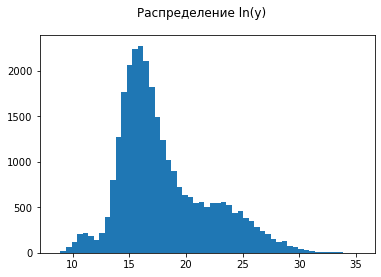

In [4]:
plt.suptitle('Распределение ln(y)')
plt.hist(y_st,label='Распределение ln(y)',bins=55)

In [5]:
lasso_regressor = linear_model.Lasso()
lasso_regressor.fit(X[:22000], y[:22000])
lasso_predictions = lasso_regressor.predict(X[22000:])
print(metrics.mean_absolute_error(lasso_predictions, y[22000:]))

3.614943016330715


In [6]:
metrics.average_precision_score([True, True, False], [True, True, True])

0.6666666666666666

In [12]:
def AUCPR_ans(pred, y_curr, tau):
    return metrics.accuracy_score(y_curr < tau, pred < tau)

In [13]:
def lasso_score(Lambda, train_size, tau):
    ss = model_selection.ShuffleSplit(n_splits = 20, test_size = 1 - train_size)
    
    met_AUCPR = []
    met_2 = []
    
    for train_indices, test_indices in ss.split(X):
        train_data = X[train_indices]
        train_labels = y[train_indices]
        test_data = X[test_indices]
        test_labels = y[test_indices]
        lasso_regressor = linear_model.Lasso(alpha=Lambda)
        lasso_regressor.fit(train_data, train_labels)
        lasso_predictions = lasso_regressor.predict(test_data)
        met_AUCPR.append(AUCPR_ans(lasso_predictions, test_labels, tau))
        met_2.append(metrics.mean_squared_error(lasso_predictions, test_labels))
    met_2 = np.array(met_2)
    met_AUCPR = np.array(met_AUCPR)
    return met_AUCPR.mean(), met_2.mean()

In [14]:
def merge_score(Lambda, train_size, tau):
    ss = model_selection.ShuffleSplit(n_splits = 20, test_size = 1 - train_size)
    
    met_AUCPR = []
    met_2 = []
    
    for train_indices, test_indices in ss.split(X):
        train_data = X[train_indices]
        train_labels = y[train_indices]
        test_data = X[test_indices]
        test_labels = y[test_indices]
        merge_regressor = linear_model.Ridge(alpha=Lambda)
        merge_regressor.fit(train_data, train_labels)
        merge_predictions = merge_regressor.predict(test_data)
        met_AUCPR.append(AUCPR_ans(merge_predictions, test_labels, tau))
        met_2.append(metrics.mean_squared_error(merge_predictions, test_labels))
    met_2 = np.array(met_2)
    met_AUCPR = np.array(met_AUCPR)
    return met_AUCPR.mean(), met_2.mean()

In [15]:
def random_forest_score(Number_Of_Trees, train_size, tau):
    ss = model_selection.ShuffleSplit(n_splits = 20, test_size = 1 - train_size)
    
    met_AUCPR = []
    met_2 = []
    
    for train_indices, test_indices in ss.split(X):
        train_data = X[train_indices]
        train_labels = y[train_indices]
        test_data = X[test_indices]
        test_labels = y[test_indices]
        RF_regressor = ensemble.RandomForestRegressor(n_estimators=Number_Of_Trees)
        RF_regressor.fit(train_data, train_labels)
        RF_predictions = RF_regressor.predict(test_data)
        met_AUCPR.append(AUCPR_ans(RF_predictions, test_labels, tau))
        met_2.append(metrics.mean_squared_error(RF_predictions, test_labels))
    met_2 = np.array(met_2)
    met_AUCPR = np.array(met_AUCPR)
    return met_AUCPR.mean(), met_2.mean()

In [16]:
def XGBoost_score(Numer_of_base_estimators, train_size, tau):
    ss = model_selection.ShuffleSplit(n_splits = 20, test_size = 1 - train_size)
    
    met_AUCPR = []
    met_2 = []
    
    for train_indices, test_indices in ss.split(X):
        train_data = X[train_indices]
        train_labels = y[train_indices]
        test_data = X[test_indices]
        test_labels = y[test_indices]
        XGB_regressor = xgb.XGBRegressor(n_estimators=Numer_of_base_estimators)
        XGB_regressor.fit(train_data, train_labels)
        XGB_predictions = XGB_regressor.predict(test_data)
        met_AUCPR.append(AUCPR_ans(XGB_predictions, test_labels, tau))
        met_2.append(metrics.mean_squared_error(XGB_predictions, test_labels))
    met_2 = np.array(met_2)
    met_AUCPR = np.array(met_AUCPR)
    return met_AUCPR.mean(), met_2.mean()

In [17]:
ts = 0.01
Tau = 20
lambdas = np.arange(0.001,0.17,0.005)
las = []
mer = []
for l in lambdas:
    mer.append(merge_score(l,ts, Tau))
    las.append(lasso_score(l,ts, Tau))
mer = np.array(mer)
las = np.array(las)



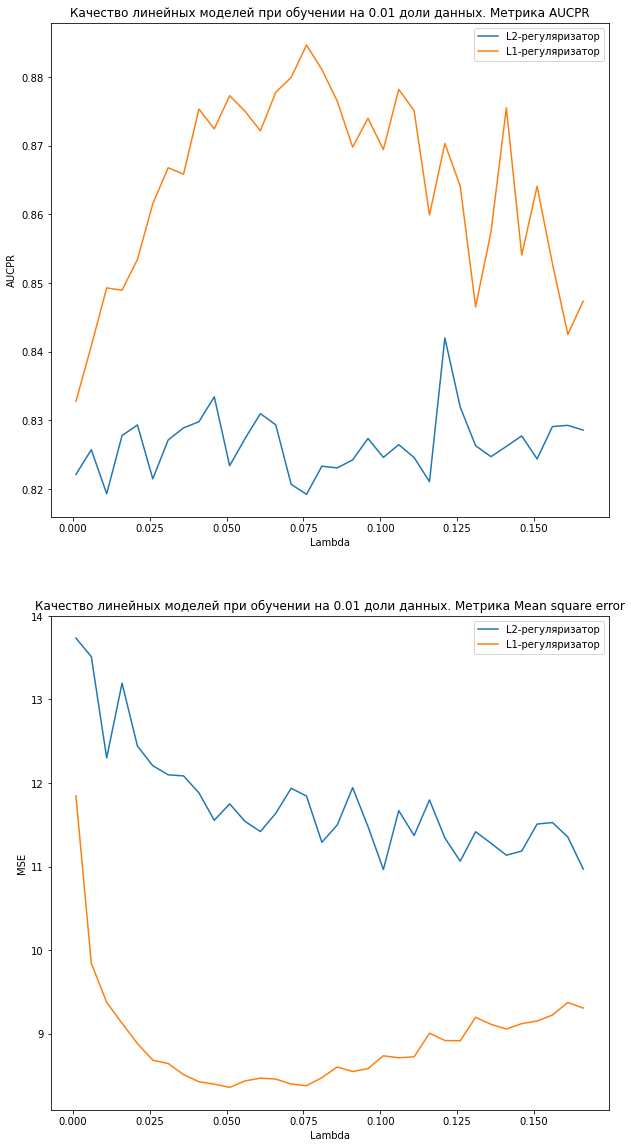

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10, 20), sharey=False)
axes[0].set_title("Качество линейных моделей при обучении на "+str(round(ts,3))+" доли данных. Метрика AUCPR")
axes[0].plot(lambdas,mer.T[0], label = "L2-регуляризатор")
axes[0].plot(lambdas,las.T[0], label = "L1-регуляризатор")
axes[0].set_xlabel("Lambda")
axes[0].set_ylabel("AUCPR")
axes[0].legend()
axes[1].set_title("Качество линейных моделей при обучении на "+str(round(ts,3))+" доли данных. Метрика Mean square error")
axes[1].plot(lambdas,mer.T[1], label = "L2-регуляризатор")
axes[1].plot(lambdas,las.T[1], label = "L1-регуляризатор")
axes[1].set_xlabel("Lambda")
axes[1].set_ylabel("MSE")
axes[1].legend()

In [19]:
ts = 0.01
Tau = 20
n_e = range(1,50)
RF = []
XGB = []
for n in n_e:
    RF.append(random_forest_score(n,ts, Tau))
    XGB.append(XGBoost_score(n,ts, Tau))
RF = np.array(RF)
XGB = np.array(XGB)

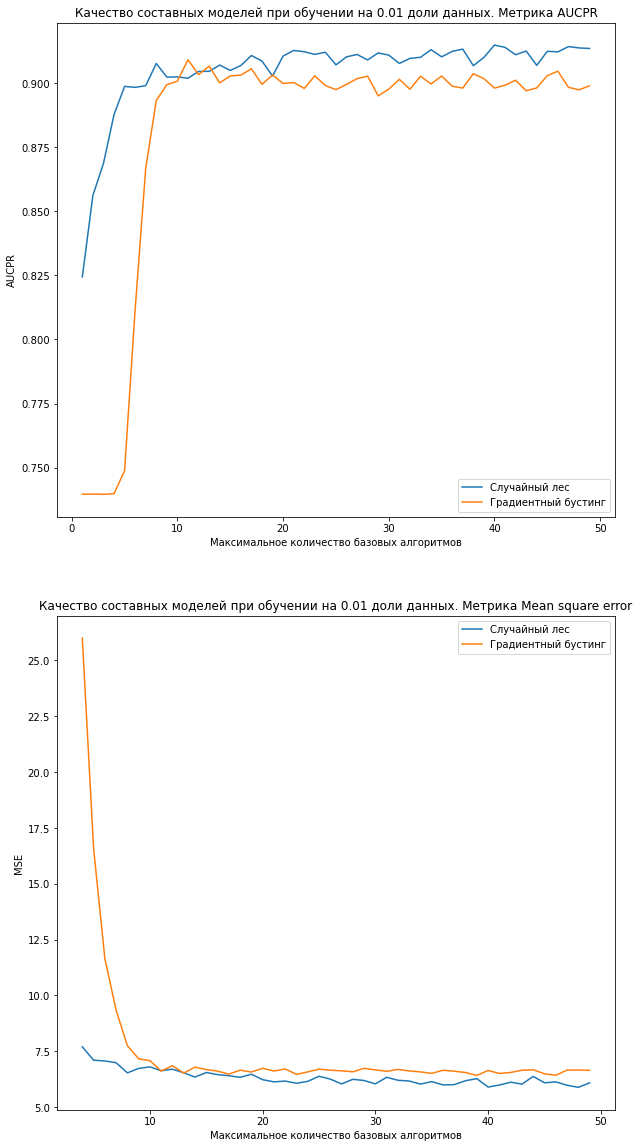

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(10, 20), sharey=False)
axes[0].set_title("Качество составных моделей при обучении на "+str(round(ts,3))+" доли данных. Метрика AUCPR")
axes[0].plot(n_e,RF.T[0], label = "Случайный лес")
axes[0].plot(n_e,XGB.T[0], label = "Градиентный бустинг")
axes[0].set_xlabel("Максимальное количество базовых алгоритмов")
axes[0].set_ylabel("AUCPR")
axes[0].legend()
axes[1].set_title("Качество составных моделей при обучении на "+str(round(ts,3))+" доли данных. Метрика Mean square error")
axes[1].plot(n_e[3:],RF.T[1][3:], label = "Случайный лес")
axes[1].plot(n_e[3:],XGB.T[1][3:], label = "Градиентный бустинг")
axes[1].set_xlabel("Максимальное количество базовых алгоритмов")
axes[1].set_ylabel("MSE")
axes[1].legend()